In [356]:
import time
import pandas as pd
import psycopg2
import datetime
from tqdm import trange
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import seaborn as sns

# %matplotlib inline 
import platform
import numpy as np
from matplotlib import font_manager, rc # plt.rcParams['axes.unicode_minus'] = False 
if platform.system() == 'Darwin': rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': 
    path = "c:/Windows/Fonts/malgun.ttf" 
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc('font', family=font_name) 
else: 
    print('Unknown system... sorry~~~~')
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
from tqdm import tqdm
from tqdm import trange

In [2]:
    # row 생략 없이 출력
pd.set_option('display.max_rows', 1000)
# col 생략 없이 출력
pd.set_option('display.max_columns', 1000)
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2

# 데이터 가져오기

In [3]:
# 전체 매장 입출판재
total_shop_stock = pd.read_csv("total_shop_stock.csv")
total_shop_stock = total_shop_stock.iloc[ :,1:]

# 매장정보
shop_info_pd = pd.read_csv("shop_info_pd.csv")
shop_info_pd = shop_info_pd.iloc[ :,1:]

# bucket_dwalker 관련 매장입출판재(2019)
bucket_dwalker = pd.read_csv('bucket_dwalker.csv')
bucket_dwalker = bucket_dwalker.iloc[ :,1:]

# bucket_dwalker_v2 관련 매장입출판재
bucket_dwalker_v2 = pd.read_csv('bucket_dwalker_v2.csv')
bucket_dwalker_v2 = bucket_dwalker_v2.iloc[ :,1:]

# 아울렛 상설을 제외한 매장키 
shop_list_pd = pd.read_csv('shop_list.csv')
shop_list_pd = shop_list_pd.iloc[ :,1:]

# 전체 매장 비어있는 주차 채운 데이터 (버킷 디워커 기준)
shop_weeks_buket_df = pd.read_csv('shop_weeks_buket.csv')
shop_weeks_buket_df = shop_weeks_buket_df.iloc[ :,1:]

# 전체 매장 비어있는 주차 채운 데이터 (버킷 디워커 v2 기준)
shop_weeks_buket_v2_df = pd.read_csv('shop_weeks_buket_v2.csv')
shop_weeks_buket_v2_df = shop_weeks_buket_v2_df.iloc[ :,1:]

# 전체 매장 비어있는것 채워넣은 입출판재 합쳐 놓은 것
shop_total_sales = pd.read_csv("shop_total_sales.csv")
shop_total_sales = shop_total_sales.iloc[ :,1:]



In [ ]:
# 2019년 - 2020년 / 디스커버리 / SH(운동화) 를 가지고 있는 매장 선택
start = time.time()

total_shop_stock_ori = '''
SELECT vfs.weekkey,vfs.shopkey ,vfs.partkey,vfs.scskey,vfs.brand,vfs.season,vfs.partcode,vfs.color,vfs.siz,vfs.week_takeout_qty,vfs.takeout_qty ,vfs.week_sale_qty ,vfs.sale_qty,vfs.week_sale_amt,vfs.stock_qty ,vfs.sale_amt,prdt.gender 
FROM ax.vw_f_scsshopweek vfs
INNER JOIN ax.vw_d_prdt prdt ON vfs.scskey  = prdt.scskey
WHERE vfs.brand = 'X' AND vfs.weekkey BETWEEN '2018-06-01' AND '2020-12-31' AND prdt.item ='SH'
'''


cur.execute(total_shop_stock_ori)
total_shop_stock_ori = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

total_shop_stock_ori = pd.DataFrame(total_shop_stock_ori)
total_shop_stock_ori.columns = ['weekkey','shopkey','partkey','scskey','brand','season','partcode','color','siz','week_takeout_qty','takeout_qty' ,'week_sale_qty' ,'sale_qty','week_sale_amt','stock_qty' ,'sale_amt','gender']
total_shop_stock = total_shop_stock_ori

In [ ]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장 

start = time.time()

shop_list = '''
SELECT shop_2019.shopkey 
FROM(SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%'  AND vds.brand = 'X' AND (closedate > '2019-12-31' OR closedate is NULL ) AND opendate < '2019-01-01'
LIMIT 1000) AS shop_2019
INNER JOIN (SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%' AND vds.brand = 'X' AND (closedate > '2020-12-31' OR closedate is NULL ) AND opendate < '2020-01-01'
) AS shop_2020
ON shop_2019.shopkey =shop_2020.shopkey
'''

cur.execute(shop_list)
shop_list = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
shop_list_pd = pd.DataFrame(shop_list)
shop_list_pd.columns = ['shopkey']

In [ ]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장  / 백화점

start = time.time()

shop_info = '''
SELECT shopkey ,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
FROM ax.vw_d_shop
WHERE type_ax_zone_nm ='국내' AND chnl_type_sfdc='오프라인'
;
'''

cur.execute(shop_info)
shop_info = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

shop_info_pd = pd.DataFrame(shop_info)
shop_info_pd.columns = ['shopkey' ,'shop_nm','shop_nm_sfdc','repr_shopcode','type_shop_nm','type_contract_nm','type_zone_nm','region_nm']

# 전처리 관련 로직

## 1.상품 한정 ( 원하는 상품군 선택 , 모든 매장에 대한 주차별 값 생성)

In [4]:
# 빠져있는 주차 채워주는 로직 (원하는 상품 관련)

def zero_fill(shopkey, base, scskey_list,item):
    total=[]
    for col in base.columns:
        base[col].values[:] = 0
    for scskey in scskey_list:
        for shop in shopkey:
            frame = base.reset_index()
            target = item[(item['scskey']==scskey) & (item['shopkey']==shop )].groupby('weekkey').sum().reset_index()
            target = target.reset_index()

            for i in range(0,len(target)):
                for j in range(0,len(frame)):
                        if target.iloc[i].weekkey == frame.iloc[j].weekkey:
                            frame.iloc[j] = target.iloc[i]
                            break
            for i in range(1,len(frame)):
                if frame.iloc[i].takeout_qty ==0 and frame.iloc[i].sale_qty==0:
                    frame.iloc[i] = [ frame.iloc[i]['weekkey'], 0, frame.iloc[i-1]['takeout_qty'], 0, frame.iloc[i-1]['sale_qty'], frame.iloc[i-1]['stock_qty']]
            frame['shopkey'] =shop
            frame['ratio'] = 0
            for i in range(0,len(frame)):
                total_sale_qty= frame['week_sale_qty'].sum()
                a = frame.iloc[i]
                if a['sale_qty']==0 :
                    frame.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0]
                else:
                    if a['sale_qty'] / total_sale_qty > 1:
                        frame.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 1]
                    else:
                        frame.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , a['sale_qty'] / total_sale_qty]
            else:
                frame['scskey']=scskey
            frame = pd.merge(frame, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
            total.append(frame)
    return total


In [ ]:
# 2019  /버킷 디워커 230~ 270 사이즈 / BE 컬러 관련 매장 입출판재컬러 관련 매장 입출판재
scskey_list = ['X19SDXSH09911BE230','X19SDXSH09911BE235','X19SDXSH09911BE240','X19SDXSH09911BE260','X19SDXSH09911BE265','X19SDXSH09911BE270']
frame = bucket_dwalker[(bucket_dwalker['scskey']=='X19SDXSH09911BE240')][['shopkey','weekkey','week_takeout_qty','takeout_qty','week_sale_qty','sale_qty','stock_qty']].groupby('weekkey').sum()
bucket_dwalker_shop_key = bucket_dwalker['shopkey'].unique()


shop_weeks_buket = zero_fill(bucket_dwalker_shop_key, frame,scskey_list,)

In [ ]:
shop_weeks_buket_df = pd.concat(shop_weeks_buket)

In [ ]:
# 2020  /버킷 디워커 V2 230~ 270 사이즈 / BE 컬러 관련 매장 입출판재컬러 관련 매장 입출판재

scskey_list = ['X20SDXSHA5011OW230','X20SDXSHA5011OW235','X20SDXSHA5011OW240','X20SDXSHA5011OW260','X20SDXSHA5011OW265','X20SDXSHA5011OW270']
frame = bucket_dwalker_v2[(bucket_dwalker_v2['scskey']=='X20SDXSHA5011OW240')][['shopkey','weekkey','week_takeout_qty','takeout_qty','week_sale_qty','sale_qty','stock_qty']].groupby('weekkey').sum()
bucket_dwalker_v2_shop_key = bucket_dwalker_v2['shopkey'].unique()


shop_weeks_buket_v2 = zero_fill(bucket_dwalker_v2_shop_key, frame,scskey_list,bucket_dwalker_v2)

In [ ]:
shop_weeks_buket_v2_df = pd.concat(shop_weeks_buket_v2)

## 2.전체 매장 입출판재 

In [ ]:
df_INNER_JOIN = pd.merge(shop_list_pd, total_shop_stock, left_on='shopkey', right_on='shopkey', how='inner')

In [ ]:
shop_stock_2019 = df_INNER_JOIN[(df_INNER_JOIN['weekkey']< '20200101') & (df_INNER_JOIN['weekkey']> '20181231') ]
shop_stock_2020 = df_INNER_JOIN[df_INNER_JOIN['weekkey']> '20191231' ]

In [ ]:
# 실제 매장 입고량과 판매량 구하는 로직(2019)
shop_stock_key_2019 = shop_stock_2019['shopkey'].unique()

total_sum_salty_2019 = []
total_sum_takeout_2019 = []
total_return_salty_2019=[]
total_sum_take_ware_2019=[]

for i in trange(0,len(shop_stock_key_2019)):
    takeout_qty = 0
    sale_qty = 0
    take_ware = 0
    return_salty=0
    
    shop_stock= shop_stock_2019[shop_stock_2019['shopkey']==shop_stock_key_2019[i]]
    shop_scs_key_2019 = shop_stock['scskey'].unique()
    for j in shop_scs_key_2019:
        takeout_qty+= shop_stock[shop_stock['scskey']==j]['takeout_qty'].max()
        sale_qty+= shop_stock[shop_stock['scskey']==j]['sale_qty'].max()
        take_ware += int(shop_stock[(shop_stock['scskey']==j)&(shop_stock['week_takeout_qty']<0)]['week_takeout_qty'].sum())
        return_salty += int(shop_stock[(shop_stock['scskey']==j)&(shop_stock['week_sale_qty']<0)]['week_sale_qty'].sum())
    total_sum_takeout_2019.append(takeout_qty)
    total_sum_salty_2019.append(sale_qty)
    total_sum_take_ware_2019.append(take_ware)
    total_return_salty_2019.append(return_salty)
df3 = pd.DataFrame([ x for x in zip(shop_stock_key_2019,total_sum_salty_2019,total_sum_takeout_2019,total_sum_take_ware_2019,total_return_salty_2019)])
df3.columns = ['shopkey','salty2019','takeout2019','take_ware2019','return_salty2019']
df3['salty2019'] = df3['salty2019'] + df3['return_salty2019']
print(df3)

In [ ]:
# 실제 매장 입고량과 판매량 구하는 로직(2020)

shop_stock_key_2020 = shop_stock_2020['shopkey'].unique()

total_sum_salty2020 = []
total_sum_takeout2020 = []
total_return_salty2020=[]
total_sum_take_ware2020=[]

for i in trange(0,len(shop_stock_key_2020)):
    takeout_qty = 0
    sale_qty = 0
    take_ware = 0
    return_salty=0
    
    shop_stock= shop_stock_2020[shop_stock_2020['shopkey']==shop_stock_key_2020[i]]
    shop_scs_key_2020 = shop_stock['scskey'].unique()
    for j in shop_scs_key_2020:
        takeout_qty+= shop_stock[shop_stock['scskey']==j]['takeout_qty'].max()
        sale_qty+= shop_stock[shop_stock['scskey']==j]['sale_qty'].max()
        take_ware += int(shop_stock[(shop_stock['scskey']==j)&(shop_stock['week_takeout_qty']<0)]['week_takeout_qty'].sum())
        return_salty += int(shop_stock[(shop_stock['scskey']==j)&(shop_stock['week_sale_qty']<0)]['week_sale_qty'].sum())
    total_sum_takeout2020.append(takeout_qty)
    total_sum_salty2020.append(sale_qty)
    total_sum_take_ware2020.append(take_ware)
    total_return_salty2020.append(return_salty)
df4 = pd.DataFrame([ x for x in zip(shop_stock_key_2020,total_sum_salty2020,total_sum_takeout2020,total_sum_take_ware2020,total_return_salty2020)])
df4.columns = ['shopkey','salty2020','takeout2020','take_ware2020','return_salty2020']
df4['salty2020'] = df4['salty2020'] + df4['return_salty2020']
df4

## 3.버킷디워커 / 버킷디워커 2 - 평균 재고 소진 비율 구하기

In [415]:
# 전체 매장 평균 판매 비율 buket
bk_department_weeks_mean = shop_weeks_buket_df[shop_weeks_buket_df['type_zone_nm']=='백화점'].groupby('weekkey').mean()
bk_agency_weeks_mean = shop_weeks_buket_df[shop_weeks_buket_df['type_zone_nm']=='대리점'].groupby('weekkey').mean()

In [416]:
# 전체 매장 평균 판매 비율 buket
bk_department_weeks_mean = bk_department_weeks_mean.reset_index()
bk_agency_weeks_mean = bk_agency_weeks_mean.reset_index()
bk_department_weeks_mean['weekkey'] = pd.to_datetime(bk_department_weeks_mean['weekkey'])
bk_agency_weeks_mean['weekkey'] = pd.to_datetime(bk_agency_weeks_mean['weekkey'])

In [417]:
bk_department_weeks_mean = bk_department_weeks_mean.set_index('weekkey')
bk_agency_weeks_mean = bk_agency_weeks_mean.set_index('weekkey')

In [418]:
# 평균 주차별 재고 소진율 차이 (버킷 디워커) 

bk_department_weeks_mean['rise_ratio'] = 0
for i in range(0,len(bk_department_weeks_mean)-1):
    a = bk_department_weeks_mean.iloc[i]
    if i ==0:
        bk_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , a[5]]
    else:
        a = bk_department_weeks_mean.iloc[i]
        bk_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , bk_department_weeks_mean['ratio'].iloc[i] - bk_department_weeks_mean['ratio'].iloc[i-1] ]


In [419]:
bk_department_weeks_mean_df = bk_department_weeks_mean.copy()

In [420]:
# 전체 매장 평균 판매 비율 buket_v2
v2_department_weeks_mean = shop_weeks_buket_v2_df[shop_weeks_buket_v2_df['type_zone_nm']=='백화점'].groupby('weekkey').mean()
v2_agency_weeks_mean = shop_weeks_buket_v2_df[shop_weeks_buket_v2_df['type_zone_nm']=='대리점'].groupby('weekkey').mean()

In [421]:
# 전체 매장 평균 판매 비율 buket_v2
v2_department_weeks_mean = v2_department_weeks_mean.reset_index()
v2_agency_weeks_mean = v2_agency_weeks_mean.reset_index()
v2_department_weeks_mean['weekkey'] = pd.to_datetime(v2_department_weeks_mean['weekkey'])
v2_agency_weeks_mean['weekkey'] = pd.to_datetime(v2_agency_weeks_mean['weekkey'])

In [422]:
v2_department_weeks_mean = v2_department_weeks_mean.set_index('weekkey')
v2_agency_weeks_mean = v2_agency_weeks_mean.set_index('weekkey')

In [423]:
# 평균 주차별 재고 소진율 차이 (버킷 디워커 v2) 

v2_department_weeks_mean['rise_ratio'] = 0
for i in range(0,len(v2_department_weeks_mean)-1):
    a = v2_department_weeks_mean.iloc[i]
    if i ==0:
        v2_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , a[5]]
    else:
        a = v2_department_weeks_mean.iloc[i]
        v2_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , v2_department_weeks_mean['ratio'].iloc[i] - v2_department_weeks_mean['ratio'].iloc[i-1] ]

In [424]:
v2_department_weeks_mean_df = v2_department_weeks_mean.copy()

## 4.매장별 평균 소진비율 구하기

In [313]:
# 버킷디워커 (2019)  + 백화점 
de_shop_weeks_buket_df = shop_weeks_buket_df[shop_weeks_buket_df['type_zone_nm']=='백화점']
bk_total_shop_ratio = []
for shop_key in de_shop_weeks_buket_df['shopkey'].unique():
    shop_week = de_shop_weeks_buket_df[de_shop_weeks_buket_df['shopkey']== shop_key].groupby('weekkey').sum()
    shop_week = shop_week.reset_index()
    shop_week['weekkey'] = pd.to_datetime(shop_week['weekkey'])
    
    shop_week['ratio'] = 0
    shop_week['shopkey'] = 0
    shop_week['rise_ratio'] = 0
    
    for i in range(0,len(shop_week)):
        total_sale_qty= shop_week['week_sale_qty'].sum()
        a = shop_week.iloc[i]
        if a['sale_qty']==0 :
#             shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0,0]
            shop_week.iloc[i] = [a[0],a[1],a[2] ,a[3] ,a[4] ,a[5], 0,shop_key,0]

        else:
            if a['sale_qty'] / total_sale_qty > 1:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5], 1,shop_key,0]
            else:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5], a['sale_qty'] / total_sale_qty,shop_key,0]
        a = shop_week.iloc[i]
        if i == 0:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],a[8]]
        else:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],shop_week.iloc[i]['ratio'] - shop_week.iloc[i-1]['ratio']]

    bk_total_shop_ratio.append(shop_week)


In [314]:
bk_total_shop_ratio = pd.concat(bk_total_shop_ratio)

In [315]:
bk_total_shop_ratio

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio,shopkey,rise_ratio
0,2018-12-31,4,4,0,0,4,0.000000,X10056,0.000000
1,2019-01-07,0,4,0,0,4,0.000000,X10056,0.000000
2,2019-01-14,3,7,1,1,6,0.012195,X10056,0.012195
3,2019-01-21,0,7,1,2,5,0.024390,X10056,0.012195
4,2019-01-28,-1,6,1,3,3,0.036585,X10056,0.012195
...,...,...,...,...,...,...,...,...,...
48,2019-12-02,-1,229,0,226,3,0.995595,X10038,0.000000
49,2019-12-09,1,230,1,227,3,1.000000,X10038,0.004405
50,2019-12-16,0,230,-1,226,4,0.995595,X10038,-0.004405
51,2019-12-23,0,230,0,226,4,0.995595,X10038,0.000000


In [321]:
bk_total_shop_ratio_info = pd.merge(bk_total_shop_ratio,shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
bk_total_shop_ratio_info

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio,shopkey,rise_ratio,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,2018-12-31,4,4,0,0,4,0.000000,X10056,0.000000,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
1,2019-01-07,0,4,0,0,4,0.000000,X10056,0.000000,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
2,2019-01-14,3,7,1,1,6,0.012195,X10056,0.012195,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
3,2019-01-21,0,7,1,2,5,0.024390,X10056,0.012195,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
4,2019-01-28,-1,6,1,3,3,0.036585,X10056,0.012195,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546,2019-12-02,-1,229,0,226,3,0.995595,X10038,0.000000,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
3547,2019-12-09,1,230,1,227,3,1.000000,X10038,0.004405,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
3548,2019-12-16,0,230,-1,226,4,0.995595,X10038,-0.004405,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
3549,2019-12-23,0,230,0,226,4,0.995595,X10038,0.000000,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남


In [437]:
# 버킷디워커 v2
de_shop_weeks_v2_df = shop_weeks_buket_v2_df[shop_weeks_buket_v2_df['type_zone_nm']=='백화점']

v2_total_shop_ratio = []
for shop_key in de_shop_weeks_v2_df['shopkey'].unique():
    shop_week = de_shop_weeks_v2_df[de_shop_weeks_v2_df['shopkey']== shop_key].groupby('weekkey').sum()
    shop_week = shop_week.reset_index()
    shop_week['weekkey'] = pd.to_datetime(shop_week['weekkey'])
    
    shop_week['ratio'] = 0
    shop_week['shopkey'] = 0
    shop_week['rise_ratio'] = 0
    
    for i in range(0,len(shop_week)):
        total_sale_qty= shop_week['week_sale_qty'].sum()
        a = shop_week.iloc[i]
        if a['sale_qty']==0 :
#             shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0,0]
            shop_week.iloc[i] = [a[0],a[1],a[2] ,a[3] ,a[4] ,a[5], 0,shop_key,0]

        else:
            if a['sale_qty'] / total_sale_qty > 1:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5], 1,shop_key,0]
            else:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5], a['sale_qty'] / total_sale_qty,shop_key,0]
        a = shop_week.iloc[i]
        if i == 0:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],a[8]]
        else:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],shop_week.iloc[i]['ratio'] - shop_week.iloc[i-1]['ratio']]

    v2_total_shop_ratio.append(shop_week)

In [438]:
v2_total_shop_ratio = pd.concat(v2_total_shop_ratio)

In [439]:
v2_total_shop_ratio

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio,shopkey,rise_ratio
0,2019-11-18,6,6,0,0,6,0.000000,X10056,0.000000
1,2019-11-25,0,6,1,1,5,0.013333,X10056,0.013333
2,2019-12-02,5,11,3,4,7,0.053333,X10056,0.040000
3,2019-12-09,2,13,1,5,8,0.066667,X10056,0.013333
4,2019-12-16,2,15,0,5,10,0.066667,X10056,0.000000
...,...,...,...,...,...,...,...,...,...
54,2020-11-30,2,348,2,312,36,0.975000,X10038,0.006250
55,2020-12-07,1,349,4,316,33,0.987500,X10038,0.012500
56,2020-12-14,0,349,0,316,33,0.987500,X10038,0.000000
57,2020-12-21,0,349,2,318,31,0.993750,X10038,0.006250


In [440]:
v2_total_shop_ratio_info = pd.merge(v2_total_shop_ratio,shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
v2_total_shop_ratio_info

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio,shopkey,rise_ratio,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,2019-11-18,6,6,0,0,6,0.000000,X10056,0.000000,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
1,2019-11-25,0,6,1,1,5,0.013333,X10056,0.013333,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
2,2019-12-02,5,11,3,4,7,0.053333,X10056,0.040000,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
3,2019-12-09,2,13,1,5,8,0.066667,X10056,0.013333,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
4,2019-12-16,2,15,0,5,10,0.066667,X10056,0.000000,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,2020-11-30,2,348,2,312,36,0.975000,X10038,0.006250,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
3949,2020-12-07,1,349,4,316,33,0.987500,X10038,0.012500,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
3950,2020-12-14,0,349,0,316,33,0.987500,X10038,0.000000,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
3951,2020-12-21,0,349,2,318,31,0.993750,X10038,0.006250,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남


# 전체 매장 입출판재 + 매장 info 데이터

In [17]:
shop_total_sales_info = pd.merge(shop_total_sales,shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
shop_total_sales_info

,shopkey,총 판매량(2019),총 입고량(2019),총 판매량(2020),총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),판매 비율(19/19),판매 비율(20/20),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10070,2842,4298,8776,11012,3.087966,2.562122,0.661238,0.796949,신세계강남,디스커버리 신세계 강남점,XH0260,일반매장,백화점특정,백화점,서울
1,X10057,2842,4881,7257,9722,2.553483,1.991805,0.582258,0.746451,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
2,X10050,5668,8376,14182,17873,2.502117,2.133835,0.676695,0.793487,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
3,X10027,2984,4782,7036,11932,2.357909,2.495190,0.624007,0.589675,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
4,X10006,4823,6728,11168,13899,2.315571,2.065844,0.716855,0.803511,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기
5,X50057,797,2074,1839,3064,2.307403,1.477338,0.384282,0.600196,여천(대-위),디스커버리 여천점,XH0061,일반매장,대리점,대리점,전남
6,X10064,3726,5409,8488,10827,2.278046,2.001664,0.688852,0.783966,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
7,X50001,1824,3257,4049,5758,2.219846,1.767885,0.560025,0.703196,목포하당(대-위),디스커버리 목포하당점,XH0004,일반매장,대리점,대리점,전남
8,X10056,1611,2841,3433,4801,2.130975,1.689898,0.567054,0.715059,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
9,X50005,1035,2311,2181,3444,2.107246,1.490264,0.447858,0.633275,여수(대-위),디스커버리 여수점,XH0005,일반매장,대리점,대리점,전남


In [18]:
# 백화점 / 대리점 추출

department_total_sales = shop_total_sales_info[shop_total_sales_info['type_zone_nm']=='백화점']
agency_total_sales = shop_total_sales_info[shop_total_sales_info['type_zone_nm']=='대리점']

# 그룹화

## 1.분위수별

In [19]:
# 2019년 판매량 관련 분위수

d_Q1_2019 = department_total_sales['총 판매량(2019)'].quantile(.25)
d_Q3_2019 = department_total_sales['총 판매량(2019)'].quantile(.75)
d_IQR_2019 = d_Q3_2019 - d_Q1_2019
d_Q2_2019 = department_total_sales['총 판매량(2019)'].quantile(.5)
d_Q4_2019 = department_total_sales['총 판매량(2019)'].quantile(1)
d_Q0_2019 = department_total_sales[((department_total_sales['총 판매량(2019)']>d_Q3_2019+1.5*d_IQR_2019))]

In [20]:
d_q4_2019 = department_total_sales[department_total_sales['총 판매량(2019)']<d_Q1_2019]
d_q3_2019 = department_total_sales[(department_total_sales['총 판매량(2019)']>d_Q1_2019)&(department_total_sales['총 판매량(2019)']<d_Q2_2019)]
d_q2_2019 = department_total_sales[(department_total_sales['총 판매량(2019)']>d_Q2_2019)&(department_total_sales['총 판매량(2019)']<d_Q3_2019)]
d_q1_2019 = department_total_sales[(department_total_sales['총 판매량(2019)']>d_Q3_2019)&(department_total_sales['총 판매량(2019)']<d_Q3_2019+1.5*d_IQR_2019)]
d_q0_2019 = department_total_sales[((department_total_sales['총 판매량(2019)']>d_Q3_2019+1.5*d_IQR_2019))]

In [21]:
# 2020 년 판매량 관련 분위수

d_Q1_2020 = department_total_sales['총 판매량(2020)'].quantile(.25)
d_Q3_2020 = department_total_sales['총 판매량(2020)'].quantile(.75)
d_IQR_2020 = d_Q3_2020 - d_Q1_2020
d_Q2_2020 = department_total_sales['총 판매량(2020)'].quantile(.5)
d_Q4_2020 = department_total_sales['총 판매량(2020)'].quantile(1)
d_Q0_2020 = department_total_sales[((department_total_sales['총 판매량(2020)']>d_Q3_2020+1.5*d_IQR_2020))]

In [22]:
d_q4_2020 = department_total_sales[department_total_sales['총 판매량(2020)']<d_Q1_2020]
d_q3_2020 = department_total_sales[(department_total_sales['총 판매량(2020)']>d_Q1_2020)&(department_total_sales['총 판매량(2020)']<d_Q2_2020)]
d_q2_2020 = department_total_sales[(department_total_sales['총 판매량(2020)']>d_Q2_2020)&(department_total_sales['총 판매량(2020)']<d_Q3_2020)]
d_q1_2020 = department_total_sales[(department_total_sales['총 판매량(2020)']>d_Q3_2020)&(department_total_sales['총 판매량(2020)']<d_Q3_2020+1.5*d_IQR_2020)]
d_q0_2020 = department_total_sales[((department_total_sales['총 판매량(2020)']>d_Q3_2020+1.5*d_IQR_2020))]

In [105]:
d_q4_2019['quantile'] = 'Q4'
d_q3_2019['quantile'] = 'Q3'
d_q2_2019['quantile'] = 'Q2'
d_q1_2019['quantile'] = 'Q1'
d_q0_2019['quantile'] = 'Q0'

<ipython-input-105-10d89d940764>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_q4_2019['quantile'] = 'Q4'
<ipython-input-105-10d89d940764>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_q3_2019['quantile'] = 'Q3'
<ipython-input-105-10d89d940764>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [110]:
d_2019_quantile = [d_q0_2019,d_q1_2019,d_q2_2019,d_q3_2019,d_q4_2019]
d_2019_quantile = pd.concat(d_2019_quantile)

In [104]:
d_q4_2020['quantile'] = 'Q4'
d_q3_2020['quantile'] = 'Q3'
d_q2_2020['quantile'] = 'Q2'
d_q1_2020['quantile'] = 'Q1'
d_q0_2020['quantile'] = 'Q0'

<ipython-input-104-96223640cad9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_q4_2020['quantile'] = 'Q4'
<ipython-input-104-96223640cad9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_q3_2020['quantile'] = 'Q3'
<ipython-input-104-96223640cad9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [111]:
d_2020_quantile = [d_q0_2020,d_q1_2020,d_q2_2020,d_q3_2020,d_q4_2020]
d_2020_quantile = pd.concat(d_2020_quantile)

In [507]:
# 각 분위수 설정

bk_total_shop_ratio_quantile= pd.merge(bk_total_shop_ratio, d_2019_quantile[['shopkey','quantile']], left_on='shopkey', right_on='shopkey', how='inner')
bk_quantile_shop = bk_total_shop_ratio_quantile.groupby(['weekkey','quantile']).sum().reset_index()

In [518]:
# 분위수 별 버킷 디워커 - 카운트 + ratio 생성


bk_total_quantile = []
count_list = []
rise_ratio_list = []

for quantile in bk_quantile_shop['quantile'].unique():
    count = 0
    shop_week = bk_quantile_shop[bk_quantile_shop['quantile']== quantile]
    shop_week['rise_ratio'] = 0
    
    for i in range(0,len(shop_week)):
        total_sale_qty= shop_week['week_sale_qty'].sum()
        a = shop_week.iloc[i]
        if a['sale_qty']==0 :
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0,0]
        else:
            if a['sale_qty'] / total_sale_qty > 1:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 1,0]
            else:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , a['sale_qty'] / total_sale_qty,0]
                
        if shop_week.iloc[i]['ratio'] > bk_department_weeks_mean_df.iloc[i]['ratio']:
            count += 1
        
        a = shop_week.iloc[i]
        if i == 0:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],a[7]]
        else:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],shop_week.iloc[i]['ratio'] - shop_week.iloc[i-1]['ratio']]

    else:
        count_list.append(count)
        bk_total_quantile.append(shop_week)


<ipython-input-518-1a8d71c540ef>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_week['rise_ratio'] = 0
C:\Users\AD0486\anaconda3\lib\site-packages\pandas\core\indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [473]:
bk_total_quantile_df = pd.concat(bk_total_quantile)

In [474]:
# 분위수 카운트

bk_quantile_count = pd.DataFrame([ x for x in zip(bk_quantile_shop['quantile'],count_list)])
bk_quantile_count.columns=['quantile(2019)','count(2019)']

In [477]:
# 각 분위수 설정

v2_total_shop_ratio_quantile= pd.merge(v2_total_shop_ratio, d_2020_quantile[['shopkey','quantile']], left_on='shopkey', right_on='shopkey', how='inner')
v2_quantile_shop = v2_total_shop_ratio_quantile.groupby(['weekkey','quantile']).sum().reset_index()

In [478]:
# 분위수 별 버킷 디워커 v2 - 카운트 + ratio 생성

v2_total_quantile = []
count_list = []
for quantile in v2_quantile_shop['quantile'].unique():
    count = 0
    shop_week = v2_quantile_shop[v2_quantile_shop['quantile']== quantile]
    shop_week['rise_ratio'] = 0
    
    for i in range(0,len(shop_week)):
        total_sale_qty= shop_week['week_sale_qty'].sum()
        a = shop_week.iloc[i]
        if a['sale_qty']==0 :
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0,0]
        else:
            if a['sale_qty'] / total_sale_qty > 1:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 1,0]
            else:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , a['sale_qty'] / total_sale_qty,0]
                
        if shop_week.iloc[i]['ratio'] > v2_department_weeks_mean.iloc[i]['ratio']:
            count += 1
        
        a = shop_week.iloc[i]
        if i == 0:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],a[7]]
        else:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],shop_week.iloc[i]['ratio'] - shop_week.iloc[i-1]['ratio']]

    else:
        count_list.append(count)
        v2_total_quantile.append(shop_week) 

<ipython-input-478-504497e6d0d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_week['rise_ratio'] = 0
C:\Users\AD0486\anaconda3\lib\site-packages\pandas\core\indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [479]:
v2_total_quantile_df = pd.concat(v2_total_quantile)

In [480]:
v2_quantile_count = pd.DataFrame([ x for x in zip(v2_quantile_shop['quantile'],count_list)])
v2_quantile_count.columns=['quantile(2020)','count(2020)']

## 2. 매장별

In [481]:
# 버킷 디워커 매장별 평균 소진비율 이상 개수 카운트 

count_list = []
for shop_key in bk_total_shop_ratio_info['shopkey'].unique():
    count = 0
    shop_week = bk_total_shop_ratio[bk_total_shop_ratio['shopkey']== shop_key]
    for i in range(0,len(shop_week)):
        if shop_week.iloc[i]['ratio'] > bk_department_weeks_mean_df.iloc[i]['ratio']:
            count += 1
    else:
        count_list.append(count)

In [482]:
shop_bk_count = pd.DataFrame([ x for x in zip(bk_total_shop_ratio_info['shopkey'].unique(),count_list)])
shop_bk_count.columns=['shopkey','ratio_count(2019)']

In [483]:
bk_total_shop_ratio_info_count = pd.merge(bk_total_shop_ratio_info,shop_bk_count, left_on='shopkey', right_on='shopkey', how='inner')

In [484]:
# 버킷 디워커 v2 매장별 평균 소진비율 이상 개수 카운트 

count_list = []
for shop_key in v2_total_shop_ratio_info['shopkey'].unique():
    count = 0
    shop_week = v2_total_shop_ratio_info[v2_total_shop_ratio_info['shopkey']== shop_key]
    for i in range(0,len(shop_week)):
        if shop_week.iloc[i]['ratio'] > v2_department_weeks_mean.iloc[i]['ratio']:
            count += 1
    else:
        count_list.append(count)

In [485]:
shop_v2_count = pd.DataFrame([ x for x in zip(v2_total_shop_ratio_info['shopkey'].unique(),count_list)])
shop_v2_count.columns=['shopkey','ratio_count(2020)']

In [486]:
v2_total_shop_ratio_info_count = pd.merge(v2_total_shop_ratio_info,shop_v2_count, left_on='shopkey', right_on='shopkey', how='inner')

## 3.지역별

In [487]:
bk_region_shop = shop_weeks_buket_df[shop_weeks_buket_df['type_zone_nm']=='백화점'].groupby(['weekkey','region_nm']).sum().reset_index()

In [488]:
# 버킷 디워커 카운트

bk_total_region = []
count_list = []
for region in bk_region_shop['region_nm'].unique():
    count = 0
    shop_week = bk_region_shop[bk_region_shop['region_nm']== region]
    shop_week['rise_ratio'] = 0
    
    for i in range(0,len(shop_week)):
        total_sale_qty= shop_week['week_sale_qty'].sum()
        a = shop_week.iloc[i]
        if a['sale_qty']==0 :
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0,0]
        else:
            if a['sale_qty'] / total_sale_qty > 1:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 1,0]
            else:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , a['sale_qty'] / total_sale_qty,0]
                
        if shop_week.iloc[i]['ratio'] > bk_department_weeks_mean_df.iloc[i]['ratio']:
            count += 1
        
        a = shop_week.iloc[i]
        if i == 0:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],a[7]]
        else:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],shop_week.iloc[i]['ratio'] - shop_week.iloc[i-1]['ratio']]

    else:
        count_list.append(count)
        bk_total_region.append(shop_week) 

<ipython-input-488-3d55a36dc509>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_week['rise_ratio'] = 0


In [489]:
# 지역별 버킷디워커 재고 소진율

bk_total_region_df = pd.concat(bk_total_region)

In [491]:
bk_region_count = pd.DataFrame([ x for x in zip(bk_region_shop['region_nm'].unique(),count_list)])
bk_region_count.columns = ['지역','개수']

In [493]:
bk_region_count

,지역,개수
0,강원,3
1,경기,34
2,경남,45
3,경북,7
4,광주,53
5,대구,32
6,대전,15
7,부산,51
8,서울,48
9,울산,27


In [537]:
v2_region_shop = shop_weeks_buket_v2_df[shop_weeks_buket_v2_df['type_zone_nm']=='백화점'].groupby(['weekkey','region_nm']).sum().reset_index()

In [538]:
# 버킷 디워커 v2 카운트

v2_total_region = []

count_list=[]
for region in v2_region_shop['region_nm'].unique():
    count = 0
    shop_week = v2_region_shop[v2_region_shop['region_nm']== region]
    shop_week['rise_ratio'] = 0
    
    for i in range(0,len(shop_week)):
        total_sale_qty= shop_week['week_sale_qty'].sum()
        a = shop_week.iloc[i]
        if a['sale_qty']==0 :
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 0,0]
        else:
            if a['sale_qty'] / total_sale_qty > 1:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , 1,0]
            else:
                shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] , a['sale_qty'] / total_sale_qty,0]
                
        if shop_week.iloc[i]['ratio'] > v2_department_weeks_mean.iloc[i]['ratio']:
            count += 1
        
        a = shop_week.iloc[i]
        if i == 0:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],a[7]]
        else:
            shop_week.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5],a[6] ,a[7],shop_week.iloc[i]['ratio'] - shop_week.iloc[i-1]['ratio']]

    else:
        count_list.append(count)
        v2_total_region.append(shop_week) 

<ipython-input-538-c7cb8b6bc340>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_week['rise_ratio'] = 0
C:\Users\AD0486\anaconda3\lib\site-packages\pandas\core\indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [539]:
# 지역별 버킷디워커 v2 재고 소진율

v2_total_region_df = pd.concat(v2_total_region)

In [498]:
v2_region_count = pd.DataFrame([ x for x in zip(v2_region_shop['region_nm'].unique(),count_list)])
v2_region_count.columns = ['지역','개수']

In [499]:
v2_region_count

,지역,개수
0,강원,16
1,경기,54
2,경남,2
3,경북,4
4,광주,41
5,대구,30
6,대전,2
7,부산,40
8,서울,51
9,울산,31


# 재고 소진율 차이

In [192]:
# 평균 주차별 재고 소진율 차이 (버킷 디워커) 

bk_department_weeks_mean['ratio_sub'] = 0
for i in range(0,len(bk_department_weeks_mean)-1):
    a = bk_department_weeks_mean.iloc[i]
    if i ==0:
        bk_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , a[5]]
    else:
        a = bk_department_weeks_mean.iloc[i]
        bk_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , bk_department_weeks_mean['ratio'].iloc[i] - bk_department_weeks_mean['ratio'].iloc[i-1] ]

In [193]:
# 평균 주차별 재고 소진율 차이 (버킷 디워커) 

v2_department_weeks_mean['ratio_sub'] = 0
for i in range(0,len(v2_department_weeks_mean)-1):
    a = v2_department_weeks_mean.iloc[i]
    if i ==0:
        v2_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , a[5]]
    else:
        a = v2_department_weeks_mean.iloc[i]
        v2_department_weeks_mean.iloc[i] = [a[0],a[1] ,a[2] ,a[3] ,a[4] ,a[5] , v2_department_weeks_mean['ratio'].iloc[i] - v2_department_weeks_mean['ratio'].iloc[i-1] ]

In [326]:
v2_department_weeks_mean

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio,ratio_sub
weekkey,,,,,,,
2019-11-18,1.820896,1.820896,0.243781,0.243781,1.577114,0.006536,0.006536
2019-11-25,0.619403,2.440299,0.475124,0.718905,1.721393,0.020200,0.013664
2019-12-02,0.858209,3.298507,0.639303,1.358209,1.940299,0.039245,0.019045
2019-12-09,0.741294,4.039801,0.646766,2.004975,2.034826,0.055812,0.016567
2019-12-16,1.129353,5.169154,0.942786,2.947761,2.221393,0.084578,0.028767
2019-12-23,0.818408,5.987562,0.902985,3.850746,2.136816,0.109595,0.025017
2019-12-30,0.937811,6.925373,0.721393,4.572139,2.353234,0.130038,0.020443
2020-01-06,0.796020,7.721393,0.818408,5.390547,2.330846,0.153647,0.023609
2020-01-13,1.228856,8.950249,0.708955,6.099502,2.850746,0.172599,0.018951


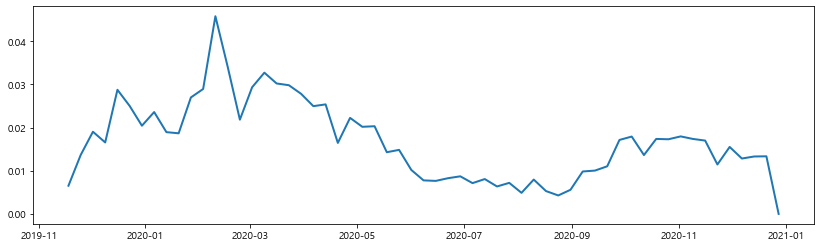

In [197]:
plt.plot(v2_department_weeks_mean.index ,v2_department_weeks_mean['ratio_sub'])

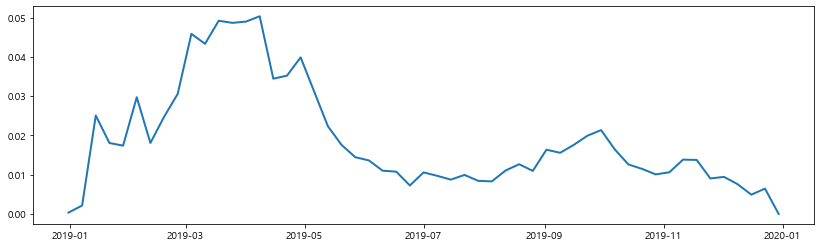

In [199]:
plt.plot(bk_department_weeks_mean.index ,bk_department_weeks_mean['ratio_sub'])

In [201]:
bk_total_region_df

,weekkey,region_nm,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,ratio
0,2018-12-31,강원,4,4,0,0,4,0.000000
14,2019-01-07,강원,0,4,0,0,4,0.000000
28,2019-01-14,강원,3,7,1,1,6,0.010309
42,2019-01-21,강원,-1,6,0,1,5,0.010309
56,2019-01-28,강원,0,6,0,1,5,0.010309
70,2019-02-04,강원,0,5,1,2,3,0.020619
84,2019-02-11,강원,1,6,0,2,4,0.020619
98,2019-02-18,강원,2,6,3,5,1,0.051546
112,2019-02-25,강원,5,10,1,6,4,0.061856
126,2019-03-04,강원,8,18,4,10,8,0.103093


## 파일 생성

In [460]:
bk_total_region_df = pd.concat(bk_total_region)
bk_total_quantile_df = pd.concat(bk_total_quantile)
bk_total_shop_ratio_info_count = pd.merge(bk_total_shop_ratio_info,shop_bk_count, left_on='shopkey', right_on='shopkey', how='inner')
bk_department_weeks_mean_df = bk_department_weeks_mean.copy()
v2_total_region_df = pd.concat(v2_total_region)
v2_total_shop_ratio_info_count = pd.merge(v2_total_shop_ratio_info,shop_v2_count, left_on='shopkey', right_on='shopkey', how='inner')
v2_total_quantile_df = pd.concat(v2_total_quantile)
v2_department_weeks_mean_df = v2_department_weeks_mean.copy()

In [426]:
bk_total_region_df.rise_ratio = round((bk_total_region_df.rise_ratio*100),2)
v2_total_region_df.rise_ratio = round((v2_total_region_df.rise_ratio*100),2)
v2_total_shop_ratio_info_count.rise_ratio = round((v2_total_shop_ratio_info_count.rise_ratio*100),2)
bk_total_shop_ratio_info_count.rise_ratio = round((bk_total_shop_ratio_info_count.rise_ratio*100),2)
v2_total_quantile_df.rise_ratio = round((v2_total_quantile_df.rise_ratio*100),2)
bk_total_quantile_df.rise_ratio = round((bk_total_quantile_df.rise_ratio*100),2)
bk_department_weeks_mean_df.rise_ratio = round((bk_department_weeks_mean_df.rise_ratio*100),2)
v2_department_weeks_mean_df.rise_ratio = round((v2_department_weeks_mean_df.rise_ratio*100),2)

In [542]:
# 지역 

bk_total_region_df.to_csv('bk_total_region_df.csv')
v2_total_region_df.to_csv('v2_total_region_df.csv')
bk_region_count.to_csv('bk_region_count.csv')
v2_region_count.to_csv('v2_region_count.csv')

In [447]:
# 매장별

v2_total_shop_ratio_info_count.to_csv('v2_total_shop_ratio_info_count.csv')
bk_total_shop_ratio_info_count.to_csv('bk_total_shop_ratio_info_count.csv')


In [430]:
# 분위수

v2_total_quantile_df.to_csv('v2_total_quantile_df.csv')
bk_total_quantile_df.to_csv('bk_total_quantile_df.csv')


In [502]:
bk_quantile_count.to_csv('bk_quantile_count.csv')
v2_quantile_count.to_csv('v2_quantile_count.csv')


In [433]:
# 평균

bk_department_weeks_mean_df.to_csv('bk_department_weeks_mean.csv')
v2_department_weeks_mean_df.to_csv('v2_department_weeks_mean.csv')